In [ ]:
from tensorflow import keras
from keras import layers
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import os, shutil

# Funções

In [ ]:
def get_true_pred(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset.unbatch().batch(1):
        y_true.append(np.argmax(labels.numpy()))
        pred = model.predict(images, verbose=0)
        y_pred.append(np.argmax(pred))
    return np.array(y_true), np.array(y_pred)

## Carregamento do dataset
Carrega o dataset distribuido pelos diferentes conjuntos de dados.

In [ ]:
train_dir = 'Dataset/archive/seg_train'
validation_dir = 'Dataset/archive/seg_val'
test_dir = 'Dataset/archive/seg_test'

train_buildings_dir = 'Dataset/archive/seg_train/buildings/'
train_forest_dir = 'Dataset/archive/seg_train/forest'
train_glacier_dir = 'Dataset/archive/seg_train/glacier'
train_mountain_dir = 'Dataset/archive/seg_train/mountain'
train_sea_dir = 'Dataset/archive/seg_train/sea'
train_street_dir = 'Dataset/archive/seg_train/street'

val_buildings_dir = 'Dataset/archive/seg_val/buildings'
val_forest_dir = 'Dataset/archive/seg_val/forest'
val_glacier_dir = 'Dataset/archive/seg_val/glacier'
val_mountain_dir = 'Dataset/archive/seg_val/mountain'
val_sea_dir = 'Dataset/archive/seg_val/sea'
val_street_dir = 'Dataset/archive/seg_val/street'

test_buildings_dir = 'Dataset/archive/seg_test/buildings'
test_forest_dir = 'Dataset/archive/seg_test/forest'
test_glacier_dir = 'Dataset/archive/seg_test/glacier'
test_mountain_dir = 'Dataset/archive/seg_test/mountain'
test_sea_dir = 'Dataset/archive/seg_test/sea'
test_street_dir = 'Dataset/archive/seg_test/street'

print('total training buildings images:', len(os.listdir(train_buildings_dir)))
print('total training forest images:', len(os.listdir(train_forest_dir)))
print('total training glacier images:', len(os.listdir(train_glacier_dir)))
print('total training mountain images:', len(os.listdir(train_mountain_dir)))
print('total training sea images:', len(os.listdir(train_sea_dir)))
print('total training street images:', len(os.listdir(train_street_dir)))

print('total validation buildings images:', len(os.listdir(val_buildings_dir)))
print('total validation forest images:', len(os.listdir(val_forest_dir)))
print('total validation glacier images:', len(os.listdir(val_glacier_dir)))
print('total validation mountain images:', len(os.listdir(val_mountain_dir)))
print('total validation sea images:', len(os.listdir(val_sea_dir)))
print('total validation street images:', len(os.listdir(val_street_dir)))

print('total test buildings images:', len(os.listdir(test_buildings_dir)))
print('total test forest images:', len(os.listdir(test_forest_dir)))
print('total test glacier images:', len(os.listdir(test_glacier_dir)))
print('total test mountain images:', len(os.listdir(test_mountain_dir)))
print('total test sea images:', len(os.listdir(test_sea_dir)))
print('total test street images:', len(os.listdir(test_street_dir)))

total training buildings images: 1691
total training forest images: 1771
total training glacier images: 1904
total training mountain images: 2012
total training sea images: 1774
total training street images: 1882
total validation buildings images: 500
total validation forest images: 500
total validation glacier images: 500
total validation mountain images: 500
total validation sea images: 500
total validation street images: 500
total test buildings images: 437
total test forest images: 474
total test glacier images: 553
total test mountain images: 525
total test sea images: 510
total test street images: 501


## Distribuição de imagens por classe e por conjunto de dados
As imagens estão distribuidas por 3 conjuntos de dados: train, validation e test.
Cada um desses conjuntos está distribuido por 6 classes: buildings, forest, glacier, mountain, sea e street.

### Número total de imagens por classe:

| Classe     | Treino | Validação | Teste | Total |
|------------|--------|-----------|-------|-------|
| Buildings  | 1691   | 500       | 437   | 2628  |
| Forest     | 1771   | 500       | 474   | 2745  |
| Glacier    | 1904   | 500       | 553   | 2957  |
| Mountain   | 2012   | 500       | 525   | 3037  |
| Sea        | 1774   | 500       | 510   | 2784  |
| Street     | 1882   | 500       | 501   | 2883  |
| **Total**  | **11034** | **3000** | **3000** | **17034** |

### Número total de imagens por conjunto de dados:

| Conjunto de dados | Total |
|-------------------|-------|
| Treino            | 11034 |
| Validação         | 3000  |
| Teste             | 3000  |
| **Total geral**   | **17034** |


# Processamento dos dados

 Carrega, redimensiona e organiza imagens em batches com rótulos one-hot, preparando os dados de treino, validação e teste.

In [ ]:
IMG_SIZE = 150
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

print(test_dataset)
class_names = train_dataset.class_names
print("Classes:", class_names)

Found 11034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Modelo (regularization: Dropout)

## Criação da CNN
Criação da CNN que irá receber imagens de 150x150 píxeis, aplica normalização e passa por quatro camadas convolucionais com max pooling para extrair características, integrando camadas Dropout para reduzir overfitting (desligando aleatoriamente 50% dos neurónios durante o treino, como forma de regularização). A rede termina com uma camada densa com 512 unidades e uma camada de saída softmax para classificação multiclasse.

In [ ]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_dropout = keras.Model(inputs, outputs)

print(model_dropout.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,686 (13.18 MB)

 Trainable params: 3,455,686 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

None


## Compilação da CNN
Compilação da CNN utilizando a loss **categorical crossentropy** e o optimizer **RMSprop**.

In [ ]:
model_dropout.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Definição do callback
Definição de um callback que guarda automaticamente o modelo com a menor perda (loss) de validação durante o treino.

In [ ]:
checkpoint_filepath = 'modelS_CatCross_RMS_dropout.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True)

## Treino da CNN
Treino da CNN durante 50 épocas utilizando o dataset de validação e o callback para guardar o melhor modelo.

In [ ]:
history_dropout = model_dropout.fit(
train_dataset,
epochs=50,
validation_data=validation_dataset,
callbacks=[model_checkpoint_callback])

Epoch 1/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4426 - loss: 1.3753 - val_accuracy: 0.5703 - val_loss: 1.1022
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6253 - loss: 0.9863 - val_accuracy: 0.6890 - val_loss: 0.8312
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.6762 - loss: 0.8629 - val_accuracy: 0.7187 - val_loss: 0.7614
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7157 - loss: 0.7780 - val_accuracy: 0.7403 - val_loss: 0.7058
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7359 - loss: 0.7181 - val_accuracy: 0.7410 - val_loss: 0.7101
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7618 - loss: 0.6633 - val_accuracy: 0.7117 - val_loss: 0.7699
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7794 - loss: 0.6241 - val_accuracy: 0.7193 - val_loss: 0.7779
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.7910 - loss: 0.5869 - 

In [ ]:
best_epoch = np.argmin(history_dropout.history['val_loss']) + 1
print(f"Melhor época (menor val_loss): {best_epoch}")

Melhor época (menor val_loss): 25


## Carregamento do modelo e validação
Carregamento e avaliação do modelo através do valor da accuracy.

In [ ]:
model_dropout = keras.models.load_model('modelS_CatCross_RMS_dropout.keras')
val_loss, val_acc = model_dropout.evaluate(validation_dataset)
print('val_acc:', val_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8406 - loss: 0.4978
val_acc: 0.8503333330154419


Representação gráfica dos valores da accuracy e da loss ao longo das épocas.

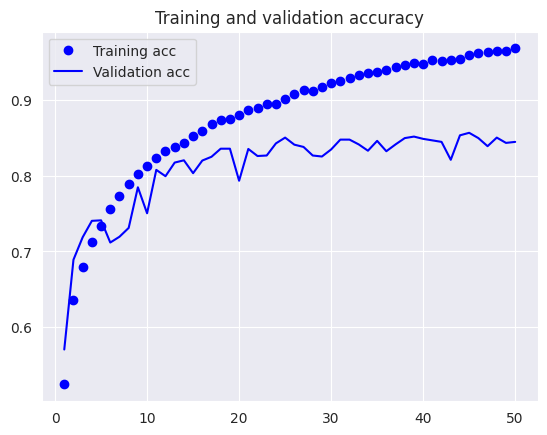

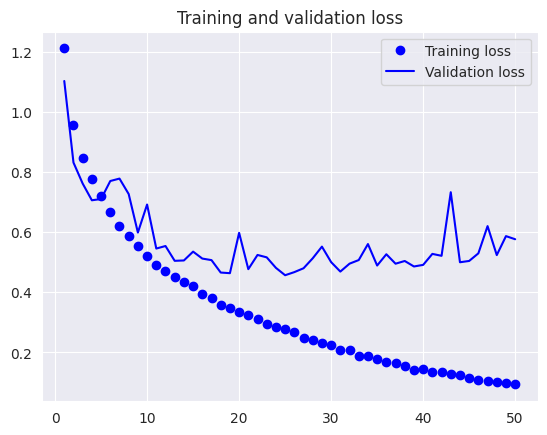

In [ ]:
acc = history_dropout.history['accuracy']
val_acc = history_dropout.history['val_accuracy']
loss = history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Avaliação da performance do modelo no conjunto de teste, utilizando o relatório de classificação. O relatório apresenta, para cada classe, as métricas precision, recall e F1-score, permitindo analisar detalhadamente os acertos e erros por classe.

In [ ]:
y_true, y_pred = get_true_pred(model_dropout, test_dataset)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
class_only_report = {k: v for k, v in report.items() if k in class_names}
df = pd.DataFrame(class_only_report).T
print(df[['precision', 'recall', 'f1-score']].round(3))


2025-06-12 22:02:18.308742: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.12 = (f32[1,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,150,150]{3,2,1,0} %bitcast.262, f32[32,3,3,3]{3,2,1,0} %bitcast.269, f32[32]{0} %bitcast.271), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_4_1/convolution" source_file="/home/diogo/.pyenv/versions/3.10.18/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-12 22:02:18.371909: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potent

           precision  recall  f1-score
buildings      0.864   0.796     0.829
forest         0.942   0.951     0.946
glacier        0.832   0.821     0.826
mountain       0.886   0.758     0.817
sea            0.776   0.931     0.847
street         0.863   0.880     0.872


2025-06-12 22:05:59.173953: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Modelo (regularization: L2)


## Criação da CNN
Criação da CNN que irá receber imagens de 150x150 píxeis, aplica normalização e passa por quatro camadas convolucionais com max pooling para extrair características, integrando regularização L2 nas camadas convolucionais para penalizar pesos excessivamente elevados e reduzir o overfitting. A rede termina com uma camada densa com 512 unidades e uma camada de saída softmax para classificação multiclasse.

In [ ]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, 3, activation="relu", kernel_regularizer='l2')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu", kernel_regularizer='l2')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu", kernel_regularizer='l2')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu", kernel_regularizer='l2')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu", kernel_regularizer='l2')(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_l2 = keras.Model(inputs, outputs)

print(model_l2.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,686 (13.18 MB)

 Trainable params: 3,455,686 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

None


## Compilação da CNN
Compilação da CNN utilizando a loss **categorical crossentropy** e o optimizer **RMSprop**.

In [ ]:
model_l2.compile(
loss='categorical_crossentropy',
optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
metrics=['acc'])

## Definição do callback
Definição de um callback que guarda automaticamente o modelo com a menor perda (loss) de validação durante o treino.

In [ ]:
checkpoint_filepath = 'modelS_CatCross_RMS_L2.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True)

## Treino da CNN
Treino da CNN durante 50 épocas utilizando o dataset de validação e o callback para guardar o melhor modelo.

In [ ]:
history_l2 = model_l2.fit(
train_dataset,
epochs=50,
validation_data=validation_dataset,
callbacks=[model_checkpoint_callback])

Epoch 1/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - acc: 0.4528 - loss: 9.2746 - val_acc: 0.5573 - val_loss: 3.6021
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - acc: 0.6091 - loss: 3.0461 - val_acc: 0.6103 - val_loss: 2.2840
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - acc: 0.6483 - loss: 2.1270 - val_acc: 0.6237 - val_loss: 1.8955
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - acc: 0.6690 - loss: 1.7784 - val_acc: 0.6527 - val_loss: 1.6544
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - acc: 0.6777 - loss: 1.5969 - val_acc: 0.6843 - val_loss: 1.5193
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - acc: 0.6881 - loss: 1.4691 - val_acc: 0.6867 - val_loss: 1.4160
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - acc: 0.6998 - loss: 1.3742 - val_acc: 0.6973 - val_loss: 1.3263
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - acc: 0.7055 - loss: 1.3055 - val_acc: 0.6417 - val_loss: 1.3917
Epoch 9/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
best_epoch = np.argmin(history_l2.history['val_loss']) + 1
print(f"Melhor época (menor val_loss): {best_epoch}")

Melhor época (menor val_loss): 49


## Carregamento do modelo e validação
Carregamento e avaliação do modelo através do valor da accuracy.

In [ ]:
model_l2 = keras.models.load_model('modelS_CatCross_RMS_L2.keras')
val_loss, val_acc = model_l2.evaluate(validation_dataset)
print('val_acc:', val_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.7978 - loss: 0.8087
val_acc: 0.7986666560173035


Representação gráfica dos valores da accuracy e da loss ao longo das épocas.

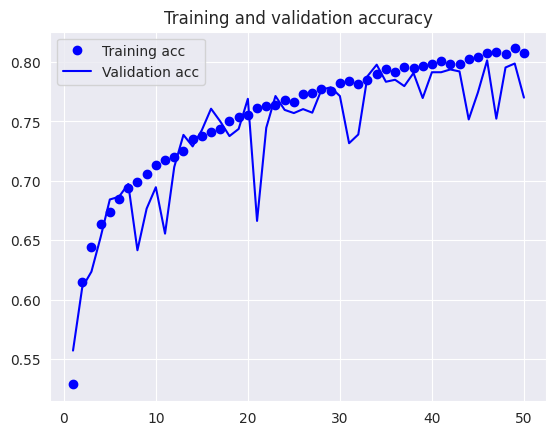

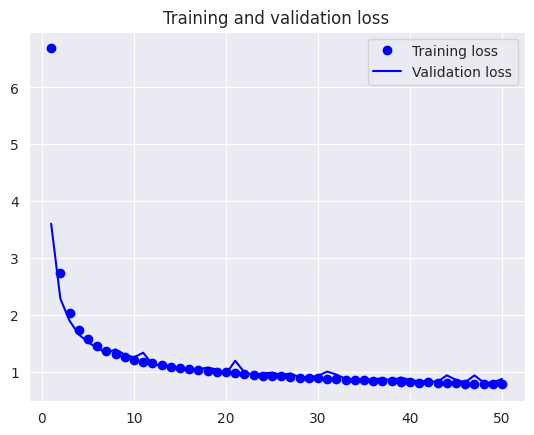

In [ ]:
acc = history_l2.history['acc']
val_acc = history_l2.history['val_acc']
loss = history_l2.history['loss']
val_loss = history_l2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Avaliação da performance do modelo no conjunto de teste, utilizando o relatório de classificação. O relatório apresenta, para cada classe, as métricas precision, recall e F1-score, permitindo analisar detalhadamente os acertos e erros por classe.

In [ ]:
y_true, y_pred = get_true_pred(model_l2, test_dataset)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
class_only_report = {k: v for k, v in report.items() if k in class_names}
df = pd.DataFrame(class_only_report).T
print(df[['precision', 'recall', 'f1-score']].round(3))


           precision  recall  f1-score
buildings      0.789   0.787     0.788
forest         0.946   0.888     0.916
glacier        0.803   0.754     0.778
mountain       0.803   0.712     0.755
sea            0.748   0.843     0.793
street         0.778   0.868     0.821


2025-06-12 22:22:18.626637: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Modelo (regularization: Dropout e L2)


## Criação da CNN
Criação da CNN que irá receber imagens de 150x150 píxeis, aplica normalização e passa por quatro camadas convolucionais com max pooling para extrair características. Integra regularização L2 nas camadas convolucionais para penalizar pesos elevados e reduzir o overfitting, e camadas Dropout que desligam aleatoriamente 50% dos neurónios durante o treino. Termina com uma camada densa com 512 unidades e uma camada de saída softmax para classificação multiclasse.


In [ ]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, 3, activation="relu", kernel_regularizer='l2')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu", kernel_regularizer='l2')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu", kernel_regularizer='l2')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu", kernel_regularizer='l2')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu", kernel_regularizer='l2')(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_both = keras.Model(inputs, outputs)

print(model_both.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,686 (13.18 MB)

 Trainable params: 3,455,686 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

None


## Compilação da CNN
Compilação da CNN utilizando a loss **categorical crossentropy** e o optimizer **RMSprop**.

In [ ]:
model_both.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Definição do callback
Definição de um callback que guarda automaticamente o modelo com a menor perda (loss) de validação durante o treino.

In [ ]:
checkpoint_filepath = 'modelS_CatCross_RMS_dropout_L2.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True)

## Treino da CNN
Treino da CNN durante 50 épocas utilizando o dataset de validação e o callback para guardar o melhor modelo.

In [ ]:
history_both = model_both.fit(
train_dataset,
epochs=50,
validation_data=validation_dataset,
callbacks=[model_checkpoint_callback])

Epoch 1/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.4214 - loss: 9.5866 - val_accuracy: 0.5413 - val_loss: 3.9742
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5933 - loss: 3.3751 - val_accuracy: 0.6030 - val_loss: 2.4343
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6382 - loss: 2.2580 - val_accuracy: 0.6430 - val_loss: 1.9492
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6604 - loss: 1.8401 - val_accuracy: 0.6463 - val_loss: 1.7115
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6727 - loss: 1.6196 - val_accuracy: 0.6677 - val_loss: 1.5477
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.6845 - loss: 1.4849 - val_accuracy: 0.6790 - val_loss: 1.4433
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6917 - loss: 1.4102 - val_accuracy: 0.6963 - val_loss: 1.3490
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.7043 - loss: 1.3289 - 

## Carregamento do modelo e validação
Carregamento e avaliação do modelo através do valor da accuracy.

In [ ]:
model_both = keras.models.load_model('modelS_CatCross_RMS_dropout_L2.keras')
val_loss, val_acc = model_both.evaluate(validation_dataset)
print('val_acc:', val_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8075 - loss: 0.8293
val_acc: 0.8056666851043701


Representação gráfica dos valores da accuracy e da loss ao longo das épocas.

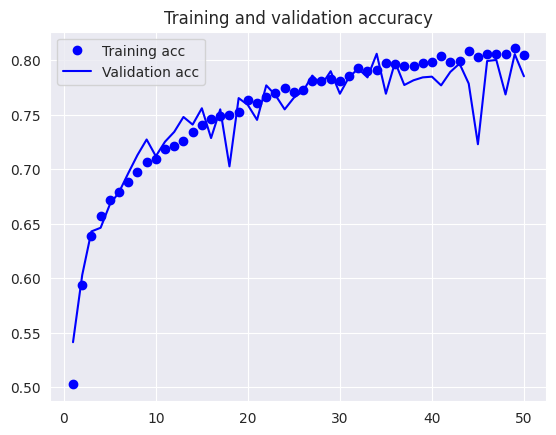

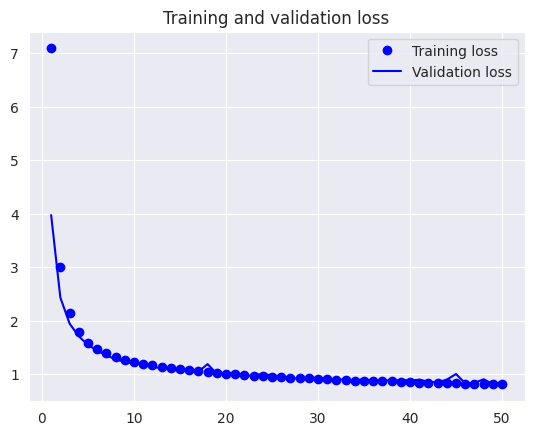

In [ ]:
acc = history_both.history['accuracy']
val_acc = history_both.history['val_accuracy']
loss_CatCros = history_both.history['loss']
val_loss = history_both.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss_CatCros, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Avaliação da performance do modelo no conjunto de teste, utilizando o relatório de classificação. O relatório apresenta, para cada classe, as métricas precision, recall e F1-score, permitindo analisar detalhadamente os acertos e erros por classe.

In [ ]:
y_true, y_pred = get_true_pred(model_both, test_dataset)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
class_only_report = {k: v for k, v in report.items() if k in class_names}
df = pd.DataFrame(class_only_report).T
print(df[['precision', 'recall', 'f1-score']].round(3))

           precision  recall  f1-score
buildings      0.820   0.721     0.767
forest         0.853   0.958     0.903
glacier        0.766   0.817     0.791
mountain       0.815   0.737     0.774
sea            0.786   0.829     0.807
street         0.840   0.806     0.823


# Avaliação do melhor modelo

## Comparação dos modelos utilizando a accuracy

In [ ]:
val_loss_CatCross_RMS_dropout, val_acc_CatCross_RMS_dropout = model_dropout.evaluate(validation_dataset)
val_loss_CatCross_RMS_l2, val_acc_CatCross_RMS_l2 = model_l2.evaluate(validation_dataset)
val_loss_CatCross_RMS_dropout_l2, val_acc_CatCross_RMS_dropout_l2 = model_both.evaluate(validation_dataset)

print("Validation Accuracy dos modelos:")
print(f"CatCross + RMSprop + Dropout: {val_acc_CatCross_RMS_dropout:.4f}")
print(f"CatCross + RMSprop + L2: {val_acc_CatCross_RMS_l2:.4f}")
print(f"CatCross + RMSprop + Dropout + L2: {val_acc_CatCross_RMS_dropout_l2:.4f}")

results = {
    'CatCross_RMS_Dropout': val_acc_CatCross_RMS_dropout,
    'CatCross_RMS_L2': val_acc_CatCross_RMS_l2,
    'CatCross_RMS_Dropout_L2': val_acc_CatCross_RMS_dropout_l2
}

# Identificar o melhor modelo com base na maior val_accuracy
best_model = max(results, key=results.get)
best_accuracy = results[best_model]

print(f"\nMelhor modelo: {best_model} com val_accuracy = {best_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8360 - loss: 0.4948
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.7997 - loss: 0.8191
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8049 - loss: 0.8338
Validation Accuracy dos modelos:
CatCross + RMSprop + Dropout: 0.4568
CatCross + RMSprop + L2: 0.8033
CatCross + RMSprop + Dropout + L2: 0.8178

Melhor modelo: CatCross_RMS_Dropout com val_accuracy = 0.8503


## Matriz de confusão do melhor modelo

2025-06-12 22:52:36.305303: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


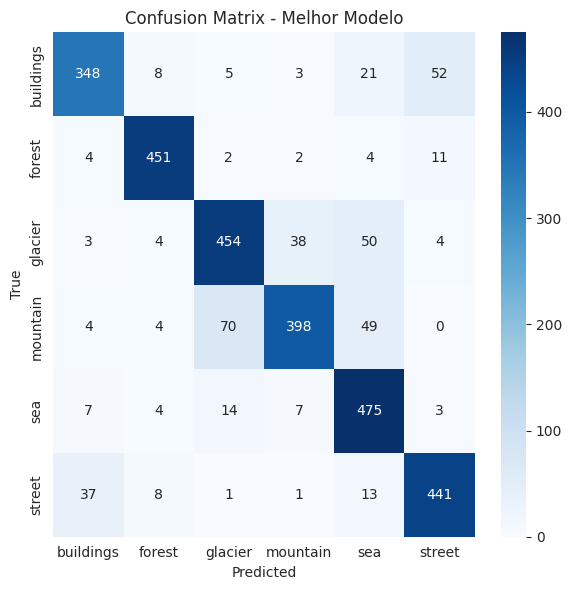

In [ ]:
y_true, y_pred = get_true_pred(model_dropout, test_dataset)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Melhor Modelo')
plt.tight_layout()
plt.show()

## Calcular saída do modelo para uma imagem

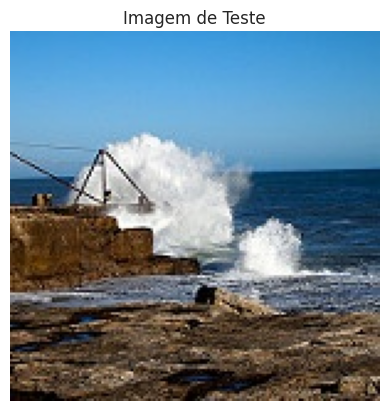

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Probabilidades por classe:
 buildings: 0.0069
    forest: 0.0004
   glacier: 0.0563
  mountain: 0.0155
       sea: 0.9200
    street: 0.0009

Classe prevista: sea (0.9200)


In [ ]:
img_path = 'Dataset/archive/seg_test/sea/20072.jpg'

img = tf.keras.preprocessing.image.load_img(
    img_path,
    target_size=(150, 150),
    interpolation='bilinear'
)

plt.imshow(img)
plt.axis('off')
plt.title("Imagem de Teste")
plt.show()

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Previsão
result = model_dropout.predict(img_array)

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print("Probabilidades por classe:")
for i, prob in enumerate(result[0]):
    print(f"{class_names[i]:>10s}: {prob:.4f}")

# Classe prevista
predicted_class = np.argmax(result)
print(f"\nClasse prevista: {class_names[predicted_class]} ({result[0][predicted_class]:.4f})")
